In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 33.54 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
%cd Mask_RCNN/
!pip3 install -r requirements.txt
!python3 setup.py install
!pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"
from pycocotools.coco import COCO

/content/Mask_RCNN
     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████| 204kB 14.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b058e4c041ccfe146da9ea84faa7f9f1f921bca5a1f52bc4e29b12e66644b6b9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [0]:
!nvidia-smi
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
##import coco
from pycocotools.coco import COCO as coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Tue May 12 03:32:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [0]:
from samples.coco import coco

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

## Create Model and Load Trained Weights

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

##Run ALL Object Detection

In [0]:
!ls

In [0]:
# Load all images from the images folder
if not os.path.exists("images/AngelaFlower"):
    os.mkdir("images/AngelaFlower")

if not os.path.exists("result"):
    os.mkdir("result")

!rm -rf /content/Mask_RCNN/images/*

def data_write(content):
	log = open("data.txt", "a")
	data.write(content)
	data.write("\n")
	data.close


!cp -r "/content/drive/My Drive/flowers/安吉拉-藤本-花/" /content/Mask_RCNN/images/
!mv /content/Mask_RCNN/images/安吉拉-藤本-花/ /content/Mask_RCNN/images/AngelaFlower/

!cp -r "/content/drive/My Drive/flowers/白色坦尼克-盆栽月季-花/白色坦尼克-盆栽月季-花/" /content/Mask_RCNN/images/
!mv /content/Mask_RCNN/images/白色坦尼克-盆栽月季-花/ /content/Mask_RCNN/images/WhiteTanic/

!cp -r "/content/drive/My Drive/flowers/蜜蜂焦糖-藤本-花/" /content/Mask_RCNN/images/
!mv /content/Mask_RCNN/images/蜜蜂焦糖-藤本-花/ /content/Mask_RCNN/images/BeeCaramel/

!cp -r "/content/drive/My Drive/flowers/黄金庆典-藤本-花/黄金庆典-藤本-花/" /content/Mask_RCNN/images/
!mv /content/Mask_RCNN/images/黄金庆典-藤本-花/ /content/Mask_RCNN/images/Golden/

!cp -r "/content/drive/My Drive/flowers/粉龙-藤本-花/" /content/Mask_RCNN/images/
!mv /content/Mask_RCNN/images/粉龙-藤本-花/ /content/Mask_RCNN/images/PinkGragon/

def detecion(path, name):
    IMAGE_DIR = path
    os.listdir(IMAGE_DIR)
    file_names = next(os.walk(IMAGE_DIR))[2]

    count = 0

    for imagefilename in file_names:
        count = count + 1
        image = skimage.io.imread(os.path.join(IMAGE_DIR, imagefilename))
        results = model.detect([image], verbose=1)

        # Visualize results
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                  class_names, r['scores'])
        
        mask = r['masks']
        class_id = r['class_ids']
        mask = mask.astype(int)
        mask.shape

        x_min, x_max, y_min, y_max = [],[],[],[]

        for z1 in range(mask.shape[2]):
          x_min.append(0)
          y_min.append(0)
          x_max.append(mask.shape[0])
          y_max.append(mask.shape[1])
          print(x_min[z1], y_min[z1], x_max[z1], x_max[z1])

        for z1 in range(mask.shape[2]):
          for x1 in range(mask.shape[0]):
            for y1 in range(mask.shape[1]): 
              if (mask[x1][y1][z1] != 0):
                if (x1>x_min[z1]):
                  x_min[z1] = x1
                if (x1<x_max[z1]):
                  x_max[z1] = x1
                if (y1>y_min[z1]):
                  y_min[z1] = y1
                if (y1<y_max[z1]):
                  y_max[z1] = y1
          print(x_min[z1], y_min[z1], x_max[z1], y_max[z1])

        for i in range(mask.shape[2]):
            temp = skimage.io.imread(os.path.join(IMAGE_DIR, imagefilename))
            #print(class_id)
            if (1):
                for j in range(temp.shape[2]):
                    temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
                plt.figure(figsize=(16,16))
                temp2 = temp[x_max[i]:x_min[i],y_max[i]:y_min[i], :]

                fileNameDestination = "result/" + name + "-" + str(count) + ".JPG"
                count = count + 1

                plt.axis('off')
                
                plt.imshow(temp2)
                plt.savefig(fileNameDestination, bbox_inches='tight', pad_inches=0)

                content = name + ";" + str(count) + ";" + x_max[i] + ";" + x_min[i] + ";" + y_max[i] + ";" + y_min[i] + ";" + mask.shape[0] + ";" + mask.shape[1]
                data_write(content)

                import shutil

                shutil.copyfile('data.txt', '/content/drive/My Drive/data.txt')

detecion("/content/Mask_RCNN/images/AngelaFlower/", "AngelaFlower")
detecion("/content/Mask_RCNN/images/WhiteTanic/", "WhiteTanic")
detecion("/content/Mask_RCNN/images/BeeCaramel/", "BeeCaramel")
detecion("/content/Mask_RCNN/images/Golden/", "Golden")
detecion("/content/Mask_RCNN/images/PinkGragon/", "PinkGragon")



In [0]:
!cp -r result "/content/drive/My Drive/DetectionResult/"
!cp  data.txt "/content/drive/My Drive/data.txt"

## Run Object Detection

/content/images
Processing 1 images
image                    shape: (1728, 2592, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2592.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


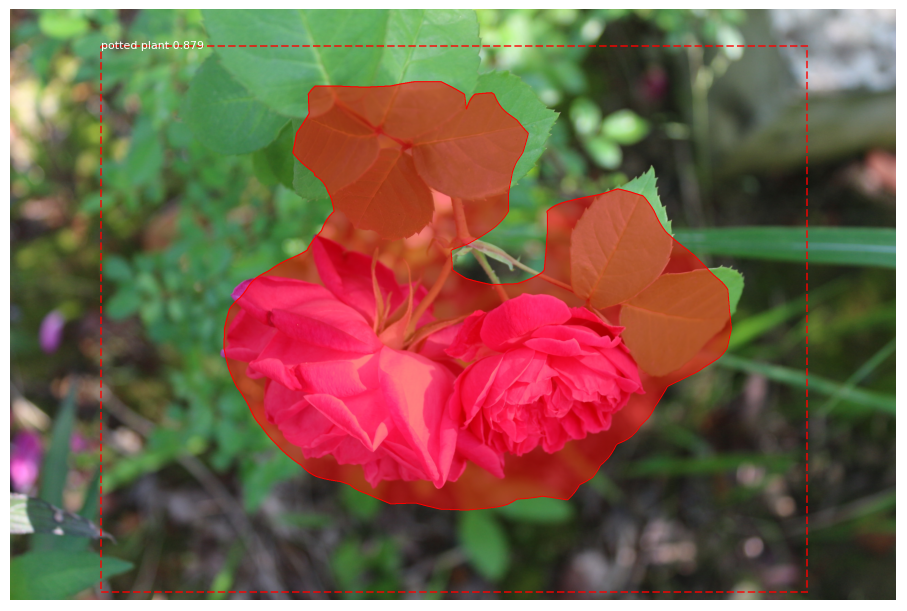

In [0]:
# Load a random image from the images folder
!cp -r "/content/drive/My Drive/flowers/安吉拉-藤本-花/" /content/images
print(IMAGE_DIR)
if not os.path.exists("result"):
    os.mkdir("result")

file_names = next(os.walk(IMAGE_DIR))[2]
DIR = file_names[22]

image = skimage.io.imread(os.path.join(IMAGE_DIR, DIR))


# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


original_image = image

(1728, 2592, 1)
0 0 1728 1728
1463 2108 211 625


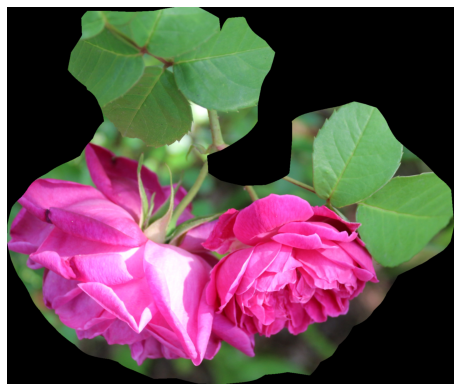

In [0]:
mask = r['masks']
class_id = r['class_ids']
mask = mask.astype(int)
print(mask.shape)

x_min, x_max, y_min, y_max = [],[],[],[]

for z1 in range(mask.shape[2]):
  x_min.append(0)
  y_min.append(0)
  x_max.append(mask.shape[0])
  y_max.append(mask.shape[1])
  print(x_min[z1], y_min[z1], x_max[z1], x_max[z1])

for z1 in range(mask.shape[2]):
  for x1 in range(mask.shape[0]):
    for y1 in range(mask.shape[1]): 
      if (mask[x1][y1][z1] != 0):
        if (x1>x_min[z1]):
          x_min[z1] = x1
        if (x1<x_max[z1]):
          x_max[z1] = x1
        if (y1>y_min[z1]):
          y_min[z1] = y1
        if (y1<y_max[z1]):
          y_max[z1] = y1
  print(x_min[z1], y_min[z1], x_max[z1], y_max[z1])

if not os.path.exists("result"):
    os.mkdir("result")

for i in range(mask.shape[2]):
    temp = skimage.io.imread(os.path.join(IMAGE_DIR, DIR))
    if (class_id[i] == 59):
        for j in range(temp.shape[2]):
            temp[:,:,j] = temp[:,:,j] * mask[:,:,i]

        #plt.figure(figsize=(8,8))
        #plt.axis('off')
        #plt.imshow(temp)
        #plt.show()
        
        temp2 = temp[x_max[i]:x_min[i],y_max[i]:y_min[i], :]
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.imshow(temp2)
        #plt.show()
        plt.savefig('temp.JPG', bbox_inches='tight', pad_inches=0)

!cp temp.JPG "/content/drive/My Drive/temp.JPG"

## Train